### Обработка данных

После долгого ожидания я получил выгрузки с данными по студентам ВШЭ. Здесь есть разное: ЕГЭ, рейтинги, выполнение тестов, учебников, курсов, подготовка к экзаменам, рейтинги и оценки.

Сначала нужно посмотреть, какие датасеты мы можем считать (тут есть разные форматы такие как csv, xlsx, ods), а далее посмотрим что у них внутри

In [1]:
import numpy as np
import pandas as pd
import os 

def try_read_table(table_name):
    if table_name.endswith("csv"):
        return pd.read_csv("Проект/" + table_name, on_bad_lines='skip', low_memory=False)
    elif table_name.endswith("xlsx"):
        return pd.read_excel("Проект/" + table_name)
    elif table_name.endswith("ods"):
        return pd.read_excel("Проект/" + table_name, engine='odf')

In [2]:
with open("info/tables_info.txt", "w") as fout:
    for table in os.listdir("./Проект"):
        df = None

        try:
            df = try_read_table(table)
        except:
            print(table + " - not parsed\n")

        if df is not None:
            fout.write(table + "\n")

Смогли считать все датасеты, теперь нужно посмотреть, что у них внутри

In [3]:
with open("info/columns_info.txt", "w") as fout:
    for table in os.listdir("./Проект"):
        df = None

        try:
            df = try_read_table(table)
        except:
            print(table + " - not parsed\n")

        if df is not None:
            fout.write(table + "\n")
            fout.write(f"Shape: {df.shape}" + "\n")
            cols = [col for col in list(df.columns.values) if "Unnamed" not in col.strip()]
            fout.write(f"Columns: \n{'\n'.join(cols)}\n\n")
            fout.write("#" * 100 + "\n\n")

Смотрим в файл **info/columns_info.txt**, чтобы понять, какие колонки у нас есть, в основном это информация о студенте (курс, группа, факультет, фио, почта) и его результаты (оценки, тесты, сдал/не сдал, баллы, проценты, перцентили и т.д.)

Теперь соберем все данные в одно место, чтобы было удобно рабоать, для этого можно записать все таблицы в список

In [4]:
dfs = []
dfs_names = []

for table in os.listdir("./Проект"):
        df = None

        try:
            df = try_read_table(table)
        except:
            print(table + " - not parsed\n")

        if df is not None:
            dfs.append(df)
            dfs_names.append(table)

print(len(dfs))

27


Теперь все таблицы лежат в списке **dfs**, их имена в **dfs_names**

Самой важной таблицей является **НЭ_с_2021я таблица для дэшборда.xlsx**, так как она содержит все данные по результатам НЭ, которые мы и хотим предсказывать, поэтому возьмем ее за базу и уже к ней будем все присоединять. Замечу, что НЭ может быть одним из 
- ЦГ           
- Прог_баз       
- Прог_нач       
- АнДан баз      
- АнДан нач      
- Прог_продв     
- АнДан прод     

поэтому важно тип экзамена, в будущем это будет фичей, чтобы модель понимала какой экзамен будет ставать студент, для этого сделаем oneHotEncoding для колонки НЭ

Так как нам нужен уникальный id для человека, брать ФИО мы не можем, так как будут коллизии, поэтому будем использовать **почту** (при коллизии к почте добавляется номер человека), при этом такой выбор согласуется с логикой, ведь было бы странно если бы вуз раздавал одинаковые почты в своем домене.

In [5]:
df = dfs[26].copy()
# Create sequence number for each email AND НЭ combination
df['seq_num'] = df.groupby(['Адрес электронной почты', 'НЭ']).cumcount() + 1

# Define columns to pivot
pivot_columns = {
    'ОЦЕНКА': 'ОЦЕНКА_',
    'Год': 'Год_',
    'Курс': 'Курс_',
    'Онлайн-курс': 'Онлайн-курс_',
    'ИУС': 'ИУС_',
    'Демо-версия': 'Демо-версия_',
    'Сдал-не-сдал': 'Сдал-не-сдал_'
}

# Create pivot tables with multi-index
pivot_tables = {
    prefix: df.pivot_table(
        index=['Адрес электронной почты', 'НЭ'],
        columns='seq_num',
        values=col,
        aggfunc='first'  # In case of duplicates, take the first value
    ).add_prefix(prefix)
    for col, prefix in pivot_columns.items()
}

# Get email and НЭ metadata (first occurrence for each combination)
email_metadata = df.groupby(['Адрес электронной почты', 'НЭ']).first()

# Combine all pivot tables
result_df = pd.concat([email_metadata] + list(pivot_tables.values()), axis=1)

columns_to_drop = [
    'Группа', 'Курс', 'ОЦЕНКА', 'Год', 'Онлайн-курс', 'ИУС', 
    'Демо-версия', 'Сдал-не-сдал', 'Сдал/не сдал',
    'Больше половины онлайн-курса', 'Чек', 'Оценка за онлайн курс'
]

result_df = (result_df
    .fillna('')
    .reset_index()
    .drop(columns=columns_to_drop)
)

base_df = result_df.copy()
base_df.rename(columns={"Адрес электронной почты": "email"}, inplace=True)

ne_encoded = pd.get_dummies(base_df['НЭ'], prefix='НЭ').astype(int)
base_df = pd.concat([base_df, ne_encoded], axis=1)
base_df.drop('НЭ', axis=1, inplace=True)


dfs.pop(26)
dfs_names.pop(26)
print(len(dfs))

base_df[base_df["email"] == "aaabbasova@edu.hse.ru"].head()

26


,email,ФИО,Филиал,Факультет,ОП,Поток,seq_num,ОЦЕНКА_1,ОЦЕНКА_2,ОЦЕНКА_3,...,Сдал-не-сдал_1,Сдал-не-сдал_2,Сдал-не-сдал_3,НЭ_АнДан баз,НЭ_АнДан нач,НЭ_АнДан прод,НЭ_Прог_баз,НЭ_Прог_нач,НЭ_Прог_продв,НЭ_ЦГ
3,aaabbasova@edu.hse.ru,Аббасова Алёна Арифовна,Москва,Факультет гуманитарных наук,Филология,22/23,1,2,,,...,0.0,,,0,1,0,0,0,0,0
4,aaabbasova@edu.hse.ru,Аббасова Алёна Арифовна,Москва,Факультет гуманитарных наук,Филология,22/23,1,3,,,...,0.0,,,0,0,0,0,1,0,0
5,aaabbasova@edu.hse.ru,Аббасова Алёна,Москва,Факультет гуманитарных наук,Филология,21/22,1,7,,,...,1.0,,,0,0,0,0,0,0,1


Дополнительно обработаем таблицу, которая имеет формат **semicolon-separated**, это таблица **Учебник_Python Оценки-20241021_0653-semicolon_separated.csv**

In [6]:
path = "Учебник_Python Оценки-20241021_0653-semicolon_separated.csv"
cur_df = pd.read_csv('Проект/' + path, sep=';', encoding='utf-8', quoting=1, low_memory=False)
print(dfs_names[14])
dfs[14] = cur_df

Учебник_Python Оценки-20241021_0653-semicolon_separated.csv


Обработаем таблицы, где почта содержит дубликаты

In [7]:
# dfs[1] - Выгрузка оценок общая 3 и 4 курсы.xlsx

cur_df = dfs[1][["Почта", "Оценка", "Раздел", "ПериодОбучения", "Дисциплина"]]
cur_df['Оценка'] = pd.to_numeric(cur_df['Оценка'], errors='coerce')

def get_last_fail_position(group):
    # Sort by ПериодОбучения in ascending order
    sorted_group = group.sort_values('ПериодОбучения')
    # Find failing grades
    failing_grades = sorted_group['Оценка'] < 4
    if failing_grades.any():
        # Get the position (0-based) of the last failing grade
        return failing_grades.values[::-1].argmax()
    return 0  # Return 0 if no failing grades

# Process Data Culture section
dc_df = cur_df[cur_df["Раздел"] == "Data Culture"].copy()
dc_latest = (dc_df.sort_values('ПериодОбучения', ascending=False)
                .groupby('Почта')
                .head(10)
                .copy())

dc_stats = dc_latest.groupby('Почта').agg({
    'Оценка': [
        ('dc_avg_grade', 'mean'),
        ('dc_grades_above_4', lambda x: (x >= 4).sum()),
        ('dc_grades_below_4', lambda x: (x < 4).sum()),
    ]
})

dc_last_fail = dc_latest.groupby('Почта').apply(get_last_fail_position)
dc_stats[('Оценка', 'dc_last_fail_position')] = dc_last_fail

# Process Major section
major_df = cur_df[cur_df["Раздел"] == "Major"].copy()
major_latest = (major_df.sort_values('ПериодОбучения', ascending=False)
                    .groupby('Почта')
                    .head(10)
                    .copy())

major_stats = major_latest.groupby('Почта').agg({
    'Оценка': [
        ('major_avg_grade', 'mean'),
        ('major_grades_above_4', lambda x: (x >= 4).sum()),
        ('major_grades_below_4', lambda x: (x < 4).sum()),
    ]
})

major_last_fail = major_latest.groupby('Почта').apply(get_last_fail_position)
major_stats[('Оценка', 'major_last_fail_position')] = major_last_fail

# Combine both statistics
dc_stats.columns = dc_stats.columns.get_level_values(1)
major_stats.columns = major_stats.columns.get_level_values(1)

# Merge the statistics
combined_stats = pd.merge(
    dc_stats, 
    major_stats, 
    left_index=True, 
    right_index=True, 
    how='outer'
).fillna(0)

# Define the independent exam types
independent_exam_types = [
    'Независимый экзамен по цифровой грамотности',
    'Независимый экзамен по программированию. Базовый уровень',
    'Независимый экзамен по программированию. Начальный уровень',
    'Независимый экзамен по анализу данных. Базовый уровень',
    'Независимый экзамен по анализу данных. Начальный уровень',
    'Независимый экзамен по программированию. Продвинутый уровень',
    'Независимый экзамен по анализу данных. Продвинутый уровень',
    'Независимый экзамен по анализу данных, искусственному интеллекту и генеративным моделям. Базовый уровень',
    'Независимый экзамен по анализу данных, искусственному интеллекту и генеративным моделям. Начальный уровень',
    'Независимый экзамен по анализу данных, искусственному интеллекту и генеративным моделям. Продвинутый уровень'
]

# Process each independent exam type
all_stats = []
for exam_type in independent_exam_types:
    # Create a short name for column prefixes
    short_name = exam_type.replace('Независимый экзамен по ', '').replace(' уровень', '').replace('. ', '_')
    short_name = short_name.replace(' ', '_').replace(',', '').lower()
    
    # Filter data for current exam type
    exam_df = cur_df[cur_df["Дисциплина"] == exam_type].copy()
    exam_latest = (exam_df.sort_values('ПериодОбучения', ascending=False)
                      .groupby('Почта')
                      .head(10)
                      .copy())
    
    # Calculate statistics
    exam_stats = exam_latest.groupby('Почта').agg({
        'Оценка': [
            (f'{short_name}_avg_grade', 'mean'),
            (f'{short_name}_grades_above_4', lambda x: (x >= 4).sum()),
            (f'{short_name}_grades_below_4', lambda x: (x < 4).sum()),
        ]
    })
    
    # Calculate last fail position
    exam_last_fail = exam_latest.groupby('Почта').apply(get_last_fail_position)
    exam_stats[(f'Оценка', f'{short_name}_last_fail_position')] = exam_last_fail
    
    # Clean up column names
    exam_stats.columns = exam_stats.columns.get_level_values(1)
    
    all_stats.append(exam_stats)

# Merge all statistics
combined_stats = pd.merge(
    combined_stats, 
    pd.concat([df for df in all_stats], axis=1),
    left_index=True,
    right_index=True,
    how='outer'
).fillna(0)

combined_stats = combined_stats.reset_index()

# Store the results
dfs_1_old = dfs[1].copy()
dfs[1] = combined_stats

combined_stats.head()

/var/folders/mm/n1h2y4wn41qcz9m9nmb5ly980000gp/T/ipykernel_19684/3575878448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['Оценка'] = pd.to_numeric(cur_df['Оценка'], errors='coerce')
/var/folders/mm/n1h2y4wn41qcz9m9nmb5ly980000gp/T/ipykernel_19684/3575878448.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dc_last_fail = dc_latest.groupby('Почта').apply(get_last_fail_position)
/var/folders/mm/n1h2y4wn41qcz9m9nmb5ly980000gp/T/ipykernel_19684

,Почта,dc_avg_grade,dc_grades_above_4,dc_grades_below_4,dc_last_fail_position,major_avg_grade,major_grades_above_4,major_grades_below_4,major_last_fail_position,цифровой_грамотности_avg_grade,...,анализу_данных_искусственному_интеллекту_и_генеративным_моделям_базовый_grades_below_4,анализу_данных_искусственному_интеллекту_и_генеративным_моделям_базовый_last_fail_position,анализу_данных_искусственному_интеллекту_и_генеративным_моделям_начальный_avg_grade,анализу_данных_искусственному_интеллекту_и_генеративным_моделям_начальный_grades_above_4,анализу_данных_искусственному_интеллекту_и_генеративным_моделям_начальный_grades_below_4,анализу_данных_искусственному_интеллекту_и_генеративным_моделям_начальный_last_fail_position,анализу_данных_искусственному_интеллекту_и_генеративным_моделям_продвинутый_avg_grade,анализу_данных_искусственному_интеллекту_и_генеративным_моделям_продвинутый_grades_above_4,анализу_данных_искусственному_интеллекту_и_генеративным_моделям_продвинутый_grades_below_4,анализу_данных_искусственному_интеллекту_и_генеративным_моделям_продвинутый_last_fail_position
0,aaabbasova@edu.hse.ru,5.60,4.0,1.0,1.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aaabdulbyarova@edu.hse.ru,8.25,4.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aaabdullin_1@edu.hse.ru,6.50,2.0,0.0,0.0,7.4,10.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aaabduragimova_1@edu.hse.ru,9.60,5.0,0.0,0.0,8.5,4.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aaaborina@edu.hse.ru,5.40,4.0,1.0,5.0,6.0,7.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# dfs[19], dfs[21] - ЕГЭ
dfs[19].dropna(subset=["Адрес студенческой почты"], inplace=True)
dfs[21].dropna(subset=["Адрес студенческой почты"], inplace=True)
print(dfs[19]['Адрес студенческой почты'].nunique(), len(dfs[19]), dfs[19]['Адрес студенческой почты'].isna().sum())
print(dfs[21]['Адрес студенческой почты'].nunique(), len(dfs[21]), dfs[21]['Адрес студенческой почты'].isna().sum())

s1 = set(dfs[19]["Адрес студенческой почты"].unique())
s2 = set(dfs[21]["Адрес студенческой почты"].unique())
print(len(s1), len(s2), len(s1.intersection(s2)))

# Берем только 21 - 'Результаты ЕГЭ.xlsx'

84308 84308 0
84308 84308 0
84308 84308 84305


In [9]:
# dfs[6] = '2024-12-11 LMS Зачетка студентов по курсам-4 курс(1).xlsx'
# Filter only independent exam records
independent_exams_df = dfs[6][dfs[6]["Дисциплина"].apply(lambda x: "независимый экзамен" in str(x).lower())]

# Create pivot table with average grades
result_df = independent_exams_df.pivot_table(
    index='Корп почта',
    columns='Дисциплина',
    values='Оценка',
    aggfunc='mean'
)

# Optionally, fill NaN values with 0 or another placeholder
result_df = result_df.fillna(0)
result_df = result_df.reset_index()
# result_df.drop(columns=["Дисциплина"], inplace=True)
# dfs[6] = result_df

dfs[6] = result_df

In [10]:
# dfs[7] = '2024-12-11 LMS Зачетка студентов по курсам-3 курс(1).xlsx'
# Filter only independent exam records
independent_exams_df = dfs[7][dfs[7]["Дисциплина"].apply(lambda x: "независимый экзамен" in str(x).lower())]

# Create pivot table with average grades
result_df = independent_exams_df.pivot_table(
    index='Корп почта',
    columns='Дисциплина',
    values='Оценка',
    aggfunc='mean'
)

# Optionally, fill NaN values with 0 or another placeholder
result_df = result_df.fillna(0)
result_df = result_df.reset_index()

dfs[7] = result_df

Итеративно найдем все колонки, где может быть почта, ведь они могут иметь разные названия в разных таблицах, получилось найти 6 разных названий

In [11]:
email_cols = set(["Адрес электронной почты", "Email address", "Адрес студенческой почты", "Логин", "Почта", "Корп почта"])

for i in range(len(dfs)):
    cols = dfs[i].columns.values
    if len(email_cols.intersection(cols)) == 0:
        print(i, dfs_names[i])
        print(cols)
        print()

Здесь написал небольшой скрипт для поиска повторений в почтах

In [12]:
email_cols = set(["Адрес электронной почты", "Email address", "Адрес студенческой почты", "Логин", "Почта", "Корп почта"])

for i in range(len(dfs)):
    for email_col in email_cols:
        if email_col in dfs[i].columns.values:
            if dfs[i][email_col].nunique() != len(dfs[i]):
                print(i, dfs_names[i], email_col)
                print(dfs[i][email_col].nunique(), len(dfs[i]))
                print()
            break

In [13]:
# base_df

for i in range(len(dfs)):
    for email_col in email_cols:
        if email_col in dfs[i].columns.values:
            # print(len(base_df))
            df_renamed = dfs[i].copy()
            df_renamed.rename(columns={col: f"{col}_{dfs_names[i]}" for col in dfs[i].columns.values}, inplace=True)

            base_df = pd.merge(base_df, df_renamed,
                                left_on='email',
                                right_on=email_col + "_" + dfs_names[i],
                                how='left',
                                suffixes=('_df1', '_df2'))
            
            base_df.drop(columns=[email_col + "_" + dfs_names[i]], inplace=True)
            # if len(base_df['email'].unique().tolist()) != len(base_df['email'].tolist()):
            #     print(dfs_names[i],dfs[i][email_col].nunique(), len(dfs[i]), "Duplicate emails!!!")
            break


base_df.head()

,email,ФИО,Филиал,Факультет,ОП,Поток,seq_num,ОЦЕНКА_1,ОЦЕНКА_2,ОЦЕНКА_3,...,Норм коэф ГР_Рейтинг 21-22 года.csv,Норм коэф_Рейтинг 21-22 года.csv,Сумма кредитов_Рейтинг 21-22 года.csv,Перцентиль_Рейтинг 21-22 года.csv,Средняя оценка_Рейтинг 21-22 года.csv,Минимальный балл_Рейтинг 21-22 года.csv,Место на ОП_Рейтинг 21-22 года.csv,Место в кампусе_Рейтинг 21-22 года.csv,Место на Курсе-ОП_Рейтинг 21-22 года.csv,Место на ОПгр_Рейтинг 21-22 года.csv
0,-___ aganbold@edu.hse.ru,Ганболд Ариунболор -,,,,23/24,1,0,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a-chan@edu.hse.ru,Чан Ань Минь -,Москва,Московский институт электроники и математики и...,Компьютерная безопасность,23/24,1,6,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aaabazova@edu.hse.ru,Абазова Алеся Алексеевна,Москва,Факультет креативных индустрий,Дизайн,23/24,1,8,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,aaabbasova@edu.hse.ru,Аббасова Алёна Арифовна,Москва,Факультет гуманитарных наук,Филология,22/23,1,2,,,...,344,"1,16",37,"27,27","8,1",7.0,112 / 397,6650 / 23755,28 / 99,28 / 99
4,aaabbasova@edu.hse.ru,Аббасова Алёна Арифовна,Москва,Факультет гуманитарных наук,Филология,22/23,1,3,,,...,344,"1,16",37,"27,27","8,1",7.0,112 / 397,6650 / 23755,28 / 99,28 / 99


При джойне я заметил, что есть много колонок с названием **Unnamed**, удалим их, так как они не несут смысловой нагрузки

In [14]:
print(len(list(base_df.columns.values)))
base_df.drop([col for col in base_df.columns.values if 'unnamed' in col.lower()], axis=1, inplace=True)
print(len(list(base_df.columns.values)))

1568
1154


Теперь нужно выделить из кучи колонок только нужные, то есть в которых полезная информация относительно учебного процесса / успеваемости


In [15]:
col_patterns = ['test', 'тест', 'оценка', 'variant', 'вариант', 'practice', 'hypothesis', 'практика'
             'гипотеза', 'задание', 'task', 'самопроверка', 'лекция', 'инструмент', 'python', 
             'глава', 'quiz', 'норм', 'сумма', 'перцентиль', 'балл', 'место', 'course', 'курс',
             'кредит', 'экзамен']

used_cols = [col for col in base_df.columns.values if any([pat in col.split('_', 1)[0].lower() for pat in col_patterns])]
df_used = base_df[used_cols + ['email']]
df_used.shape

(54405, 750)

Теперь выпишем и посмотрим глазами какие признаки нам удалось собрать

In [16]:
with open("info/processed_columns_info.txt", "w", encoding='utf-8') as fout:
    fout.write(f"Total number of columns: {len(df_used.columns)}\n\n")
    fout.write("Columns:\n")
    for i, col in enumerate(df_used.columns, 1):
        fout.write(f"{i}. {col}\n")

После фильтрации колонок мы получили огромную таблицу, которую нужно предобработать. К примеру значения "не сдал / сдал" перевести в шкалу 1 / 0. Ниже я прохожусь по всем значениям большой таблицы и пытаюсь преобзовать их в числа для дальнейшего обучения модели

Ниже я заниюмась очисткой от колонок с текстом / общими данными типа Специатет 2 курс

In [17]:
columns_to_drop = [
    'Курс_1',
    'Курс_2',
    'Курс_3',
    'Онлайн-курс_1',
    'Онлайн-курс_2',
    'Онлайн-курс_3',
    'Курс в последнем статусе_Выгрузка по ЕГЭ с 2020 года.xlsx',
    'Курс в последнем статусе_Результаты ЕГЭ.xlsx'
]

df_used.drop(columns=columns_to_drop, inplace=True)

/var/folders/mm/n1h2y4wn41qcz9m9nmb5ly980000gp/T/ipykernel_19684/255862764.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_used.drop(columns=columns_to_drop, inplace=True)


In [18]:
pat = "Специалисты 2 курс"
for column in df_used.columns:
    if df_used[column].astype(str).str.contains(pat).any():
        print(f"Found pattern {pat} in column: {column}")
        print("Example rows:")
        print(df_used[df_used[column].astype(str).str.contains(pat)][column].head())
        print("-" * 50)

In [19]:
for x in df_used.drop(columns=['email'], inplace=False).values.flatten().tolist():
    if isinstance(x, float):
        continue
    if isinstance(x, str) and x == '':
        continue
    if isinstance(x, str) and '/' in x:    
        a, b = x.split('/')
        a, b = a.strip(), b.strip()
        try:
            if a.lower() == 'null' or b.lower() == 'null':
                c = 1
            else:
                c = float(a) / float(b)
        except Exception as e:
            print(e, x)
        continue
    if x in ['Выполнено', 'Не выполнено', '-']:
        continue
    try:
        if isinstance(x, str):
            x = x.replace(',', '.')
        x = float(x)
    except Exception as e:
        print(e, x)

In [20]:
import math

def process_value(x):
    if type(x) == float and math.isnan(x):
        return 0

    if isinstance(x, float):
        return x
    if isinstance(x, str) and x == '':
        return 0
    if isinstance(x, str) and '/' in x:
        a, b = x.split('/')
        a, b = a.strip(), b.strip()
        if a.lower() == 'null' or b.lower() == 'null':
            return 1.0
        return float(a) / float(b)
    
    if isinstance(x, str):
        if x.lower() == 'выполнено':
            return 1.0
        elif x.lower() in ['не выполнено', '-']:
            return 0.0
        x = x.replace(',', '.')
    
    return float(x)

processed_df = df_used.drop(columns=['email'], inplace=False).apply(lambda x: x.apply(process_value))
processed_df['email'] = df_used['email']
processed_df.shape

(54405, 742)

Теперь в таблице processed_df все значения преобразованы в числа и можно обучать модель, но для начала нужно разделить данные на тренировочную и тестовую выборки


Из текущего датасета нужно вытащить целевую переменную, остальное берем как признаковое описание.
Таргетом будет оценка за независимый экзамен, поэтому будем использовать лишь множество почт из этой таблицы (НЭ_с_2021я таблика для дэшборда.xlsx)

Нашел ее название в общей таблице - "ОЦЕНКА_{год обучения}_НЭ_с_2021я таблица для дэшборда.xlsx", значит нужно завести новую колонку target, которая будет отвечать за последную оценку студента по НЭ, при этом если оценки нет, то мы на нем обучаться не можем, таких студентов пока просто выкинем из выборки.
И не забудем ограничить датасет по почтам, для которых мы знаем таргет.

In [21]:
import pandas as pd

# Get all grade columns
grade_cols = [f'ОЦЕНКА_{i}' for i in range(1, 4)]

# Create grade_last column by checking each grade column from right to left
processed_df['target'] = processed_df[grade_cols].replace(0, np.nan).ffill(axis=1).iloc[:, -1]
processed_df = processed_df[processed_df['target'].notna()]
print(processed_df.shape)

(52200, 743)


### Feature Engineeging

Я бы разделил фичи на классы следующим образом:
- оценка за НЭ: средняя оценка за уже пройденные, количество зачетов / незачетов, последняя оценка
- оценки в целом: средняя оценка, дисперсия оценок, мин / макс оценка
- рейтинги: место на оп / курсе / кампусе, перцентили, рейтинги
- пройденный материал: лекции / семинары / видео / тесты / квизы / главы курсов / практики / демо-варианты
- егэ: результаты егэ по математике / информатике

Для всех классов выше можно придумать как их посчитать, а для класса "пройденный материал" сделаем svd разложение, чтобы получить по "знаниям" (пройденным тестам) вектор студента и уже его значения можно будет использовать. 

Сформируем итоговый датасет

In [22]:
final_df = pd.DataFrame()
final_df["email"] = processed_df["email"]
final_df["target"] = processed_df["target"]

##### Оценки за НЭ

In [23]:
# Оценки за НЭ

def get_second_last_non_null(row):
    non_null_values = row.dropna().values
    if len(non_null_values) >= 2:
        return non_null_values[-2]
    return 0.0

def get_count_passed(row):
    non_null_values = row.dropna().values
    return len([x for x in non_null_values if x >= 4.0])

def get_count_failed(row):
    non_null_values = row.dropna().values
    return len([x for x in non_null_values if x < 4.0])


final_df['count_passed'] = processed_df[grade_cols].replace(0.0, np.nan).apply(get_count_passed, axis=1)
final_df['count_failed'] = processed_df[grade_cols].replace(0.0, np.nan).apply(get_count_failed, axis=1)

final_df['last_it_grade'] = processed_df[grade_cols].replace(0.0, np.nan).apply(get_second_last_non_null, axis=1)

grades_sum = processed_df[grade_cols].sum(axis=1)
grades_count = processed_df[grade_cols].replace(0.0, np.nan).apply(lambda row: row.count(), axis=1)
final_df['mean_ie_grade'] = grades_sum / grades_count


final_df.head()

,email,target,count_passed,count_failed,last_it_grade,mean_ie_grade
1,a-chan@edu.hse.ru,6.0,1,0,0.0,6.0
2,aaabazova@edu.hse.ru,8.0,1,0,0.0,8.0
3,aaabbasova@edu.hse.ru,2.0,0,1,0.0,2.0
4,aaabbasova@edu.hse.ru,3.0,0,1,0.0,3.0
5,aaabbasova@edu.hse.ru,7.0,1,0,0.0,7.0


array([[<Axes: title={'center': 'ОЦЕНКА_1'}>,
        <Axes: title={'center': 'ОЦЕНКА_2'}>],
       [<Axes: title={'center': 'ОЦЕНКА_3'}>, <Axes: >]], dtype=object)

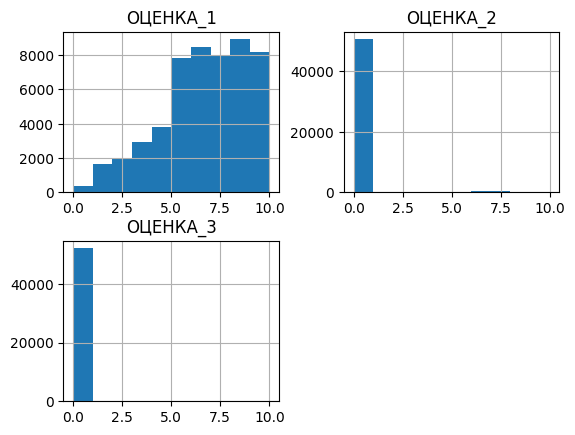

In [24]:
processed_df[grade_cols].hist()

##### Оценки в целом

In [25]:
# Оценки в целом 
grades_overall_columns = [
    "Средняя оценка_Рейтинг 21-22 года.csv",
    "Средняя оценка_Рейтинг 22-23 года.csv",
    "Средняя оценка_Рейтинг 23-24 года.csv",
]

def get_grades_mean(row):
    non_zero_values = row[row != 0]
    return non_zero_values.mean() if not non_zero_values.empty else 0.0

def last_non_zero_value(row):
    non_zero_values = row[row != 0]
    return non_zero_values.iloc[-1] if not non_zero_values.empty else 0.0

def variance_non_zero(row):
    non_zero_values = row[row != 0]
    var = non_zero_values.var() if not non_zero_values.empty else 0.0
    return var if var != np.nan else 0.0

def get_grades_min(row):
    non_zero_values = row[row != 0]
    return non_zero_values.min() if not non_zero_values.empty else 0.0


final_df['grader_overall_mean'] = processed_df[grades_overall_columns].apply(last_non_zero_value, axis=1)
final_df['last_non_zero'] = processed_df[grades_overall_columns].apply(last_non_zero_value, axis=1)
final_df['variance_non_zero'] = processed_df[grades_overall_columns].apply(variance_non_zero, axis=1).fillna(0.0)
final_df['min_non_zero'] = processed_df[grades_overall_columns].apply(get_grades_min, axis=1)

final_df.head()

,email,target,count_passed,count_failed,last_it_grade,mean_ie_grade,grader_overall_mean,last_non_zero,variance_non_zero,min_non_zero
1,a-chan@edu.hse.ru,6.0,1,0,0.0,6.0,0.00,0.00,0.000000,0.0
2,aaabazova@edu.hse.ru,8.0,1,0,0.0,8.0,0.00,0.00,0.000000,0.0
3,aaabbasova@edu.hse.ru,2.0,0,1,0.0,2.0,6.83,6.83,1.118633,6.0
4,aaabbasova@edu.hse.ru,3.0,0,1,0.0,3.0,6.83,6.83,1.118633,6.0
5,aaabbasova@edu.hse.ru,7.0,1,0,0.0,7.0,6.83,6.83,1.118633,6.0


##### Рейтинги

In [26]:
# Рейтинги
ratings_overall_columns = [
    "КР сумма_Рейтинг 22-23 года.csv",
    "КР сумма норм_Рейтинг 22-23 года.csv",
    "КРгр сумма норм_Рейтинг 22-23 года.csv",
    "Норм коэф ГР_Рейтинг 22-23 года.csv",
    "Норм коэф_Рейтинг 22-23 года.csv",
    "Сумма кредитов_Рейтинг 22-23 года.csv",
    "Перцентиль_Рейтинг 22-23 года.csv",
    "Минимальный балл_Рейтинг 22-23 года.csv",
    "Место на ОП_Рейтинг 22-23 года.csv",
    "Место в кампусе_Рейтинг 22-23 года.csv",
    "Место на Курсе-ОП_Рейтинг 22-23 года.csv",
    "Место на ОПгр_Рейтинг 22-23 года.csv",
    "КР сумма_Рейтинг 21-22 года.csv",
    "КР сумма норм_Рейтинг 21-22 года.csv",
    "КРгр сумма норм_Рейтинг 21-22 года.csv",
    "Норм коэф ГР_Рейтинг 21-22 года.csv",
    "Норм коэф_Рейтинг 21-22 года.csv",
    "Сумма кредитов_Рейтинг 21-22 года.csv",
    "Перцентиль_Рейтинг 21-22 года.csv",
    "Минимальный балл_Рейтинг 21-22 года.csv",
    "Место на ОП_Рейтинг 21-22 года.csv",
    "Место в кампусе_Рейтинг 21-22 года.csv",
    "Место на Курсе-ОП_Рейтинг 21-22 года.csv",
    "Место на ОПгр_Рейтинг 21-22 года.csv",
    "Место на ОП_Рейтинг 23-24 года.csv",
    "Место в кампусе_Рейтинг 23-24 года.csv",
    "Место на Курсе-ОП_Рейтинг 23-24 года.csv",
    "Место на ОПгр_Рейтинг 23-24 года.csv",
    "Перцентиль_Рейтинг 23-24 года.csv",
    "КР сумма_Рейтинг 23-24 года.csv",
    "КР сумма норм_Рейтинг 23-24 года.csv",
    "КРгр сумма норм_Рейтинг 23-24 года.csv",
    "Норм коэф ГР_Рейтинг 23-24 года.csv",
    "Норм коэф_Рейтинг 23-24 года.csv",
    "Сумма кредитов_Рейтинг 23-24 года.csv",
    "Минимальный балл_Рейтинг 23-24 года.csv",
]

final_df[ratings_overall_columns] = processed_df[ratings_overall_columns]

Посмотрим на статистику по рейтингам

In [27]:
table = []
for col in ratings_overall_columns:
    mi = final_df[col].min()
    ma = final_df[col].max()
    cnt = final_df[col].apply(lambda x: x != np.nan).sum()
    su = final_df[col].sum()
    cnt_zero = final_df[col].apply(lambda x: x == 0).sum()
    perc_zero = final_df[col].apply(lambda x: x == 0).sum() / len(final_df)
    table.append([col, mi, ma, cnt, su, su / cnt, final_df[col].var(), cnt_zero, perc_zero])

df = pd.DataFrame(table, columns=["name", "min", "max", "cnt", "sum", "avg", "std", "cnt_zero", "perc_zero"])
df

,name,min,max,cnt,sum,avg,std,cnt_zero,perc_zero
0,КР сумма_Рейтинг 22-23 года.csv,0.0,605.000000,52200,5.295603e+06,101.448333,17516.627726,31796,0.609119
1,КР сумма норм_Рейтинг 22-23 года.csv,0.0,882.970000,52200,7.776585e+06,148.976726,39769.333968,31796,0.609119
2,КРгр сумма норм_Рейтинг 22-23 года.csv,0.0,13.250000,52200,3.007753e+04,0.576198,0.558843,31783,0.608870
3,Норм коэф ГР_Рейтинг 22-23 года.csv,0.0,746.850000,52200,7.141019e+06,136.801129,36874.756250,33162,0.635287
4,Норм коэф_Рейтинг 22-23 года.csv,0.0,13.250000,52200,2.755941e+04,0.527958,0.517045,33152,0.635096
5,Сумма кредитов_Рейтинг 22-23 года.csv,0.0,110.000000,52200,7.693110e+05,14.737759,346.428153,31783,0.608870
6,Перцентиль_Рейтинг 22-23 года.csv,0.0,100.000000,52200,9.611952e+05,18.413701,838.571546,32025,0.613506
7,Минимальный балл_Рейтинг 22-23 года.csv,0.0,10.000000,52200,8.679800e+04,1.662797,6.485039,34092,0.653103
8,Место на ОП_Рейтинг 22-23 года.csv,0.0,1.000000,52200,9.790561e+03,0.187559,0.085727,31783,0.608870
9,Место в кампусе_Рейтинг 22-23 года.csv,0.0,0.998062,52200,9.774845e+03,0.187258,0.085513,31783,0.608870


Вообще это горазда лучше чем я ожидал, но конечно 60%+ пропусков кажется многовато

##### результаты ЕГЭ

(<Axes: >, <Axes: >)

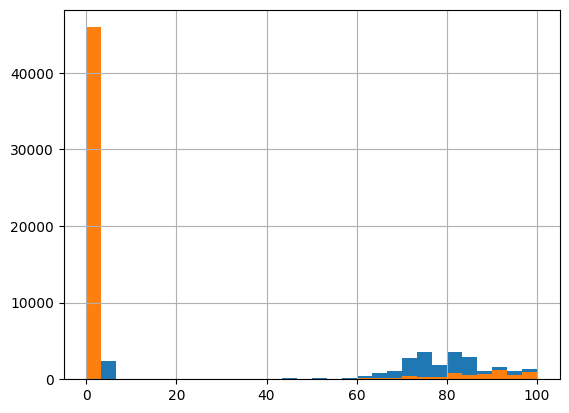

In [28]:
# ЕГЭ
final_df["Балл_ЕГЭ_математика"] = processed_df['Балл ЕГЭ Математика_Результаты ЕГЭ.xlsx']
final_df["Балл_ЕГЭ_информатика"] = processed_df['Балл ЕГЭ Информатика_Результаты ЕГЭ.xlsx']

final_df['Балл_ЕГЭ_математика'].hist(bins=30), final_df['Балл_ЕГЭ_информатика'].hist(bins=30)

Есть баллы ЕГЭ равные 3, 4, 5, должна быть ошибка в данных, так как студенты должны были сдать егэ хотя бы на порог, поэтому сами почистим такое 

In [29]:
final_df["Балл_ЕГЭ_математика"] = final_df["Балл_ЕГЭ_математика"].apply(lambda x: x if x > 20 else 0.0)
final_df["Балл_ЕГЭ_информатика"] = final_df["Балл_ЕГЭ_информатика"].apply(lambda x: x if x > 20 else 0.0)

##### Пройденный материал в виде тестов / зачетов / квизов

In [30]:
# пройденный материал
 
not_tests_columns = grade_cols + grades_overall_columns + ratings_overall_columns + ["Балл ЕГЭ_Выгрузка по ЕГЭ с 2020 года.xlsx", "target", "email"]

only_tests_columns = processed_df.drop(not_tests_columns, axis=1)

table = []
for col in only_tests_columns:
    mi = processed_df[col].min()
    ma = processed_df[col].max()
    cnt = processed_df[col].apply(lambda x: x != np.nan).sum()
    su = processed_df[col].sum()
    cnt_zero = processed_df[col].apply(lambda x: x == 0).sum()
    cnt_null = processed_df[col].apply(lambda x: x == np.nan).sum()
    table.append([col, mi, ma, cnt, su, su / cnt, processed_df[col].var(), cnt_zero, cnt_zero / len(processed_df), cnt_null])

df = pd.DataFrame(table, columns=["name", "min", "max", "cnt", "sum", "avg", "std", "cnt_zero", "cnt_zero_perc", "cnt_null"])

Выделим только те материалы, которые имеют хотя бы 1% пройденности среди стедентов, тесты с пройденностью менее процента будут добавлять лишь шум в данные, остается примерно 65% тестов от всех

In [31]:
# df[df["cnt_zero_perc"] < 0.99].size = 403
df[df["cnt_zero_perc"] < 0.99].head(10)
# df['cnt_zero_perc'].hist(bins=100)
# df['cnt_zero_perc'].quantile(0.645)

,name,min,max,cnt,sum,avg,std,cnt_zero,cnt_zero_perc,cnt_null
5,Тест:ЗАДАНИЕ А-01 (Значение)_Курс подготовки к...,0.0,10.0,52200,42287.0,0.810096,7.376472,47901,0.917644,0
6,Тест:ЗАДАНИЕ А-02 (Значение)_Курс подготовки к...,0.0,10.0,52200,37956.0,0.727126,6.605667,48271,0.924732,0
7,Тест:ЗАДАНИЕ А-03 (Значение)_Курс подготовки к...,0.0,10.0,52200,35819.0,0.686188,6.309861,48540,0.929885,0
8,Тест:ЗАДАНИЕ А-04 (Значение)_Курс подготовки к...,0.0,10.0,52200,33817.0,0.647835,5.921055,48695,0.932854,0
9,Тест:ЗАДАНИЕ А-05 (Значение)_Курс подготовки к...,0.0,10.0,52200,31690.0,0.607088,5.521013,48862,0.936054,0
10,Тест:ЗАДАНИЕ А-06 (Значение)_Курс подготовки к...,0.0,10.0,52200,29518.0,0.565479,5.137688,49047,0.939598,0
11,Тест:ЗАДАНИЕ В-01 (Значение)_Курс подготовки к...,0.0,10.0,52200,28581.0,0.547529,5.008220,49176,0.942069,0
12,Тест:ЗАДАНИЕ В-02 (Значение)_Курс подготовки к...,0.0,10.0,52200,24510.0,0.469540,4.246855,49505,0.948372,0
13,Тест:ЗАДАНИЕ В-03 (Значение)_Курс подготовки к...,0.0,10.0,52200,18470.0,0.353831,3.202642,50106,0.959885,0
14,Тест:ЗАДАНИЕ В-04 (Значение)_Курс подготовки к...,0.0,10.0,52200,21932.0,0.420153,3.950482,49930,0.956513,0


В столбцах имеем разные распределения значений, поэтому сделаем нормализацию

In [ ]:
from sklearn.preprocessing import StandardScaler

prep_cols = df[df["cnt_zero_perc"] < 0a99]["name"].values
nums_df = processed_df[prep_cols]

scaler = StandardScaler()
nums_df[nums_df.columns] = scaler.fit_transform(nums_df)
nums_df.head()

/var/folders/mm/n1h2y4wn41qcz9m9nmb5ly980000gp/T/ipykernel_19684/1270088155.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nums_df[nums_df.columns] = scaler.fit_transform(nums_df)


,Тест:ЗАДАНИЕ А-01 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-02 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-03 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-04 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-05 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-06 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-01 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-02 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-03 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-04 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,...,Глава 12. Линия тренда и предсказание значений признака_Выполнение елементов учебника по АД_база.csv,Видео | Python: корреляция_Выполнение елементов учебника по АД_база.csv,Видео | Python: корреляция — 2_Выполнение елементов учебника по АД_база.csv,Самопроверка.6_Выполнение елементов учебника по АД_база.csv,Глава 21. Линейная регрессия и метод наименьших квадратов_Выполнение елементов учебника по АД_база.csv,Глава 22. Нахождение уравнения регрессии_Выполнение елементов учебника по АД_база.csv,Глава 23. Оценка качества регрессии_Выполнение елементов учебника по АД_база.csv,Видео | Теория: оценка качества регрессии_Выполнение елементов учебника по АД_база.csv,Курс_Рейтинг 22-23 года.csv,Курс_Рейтинг 21-22 года.csv
1,-0.298275,-0.282915,-0.273173,-0.266237,-0.258373,-0.249481,-0.244664,-0.227847,-0.197718,-0.211391,...,-0.130113,-0.106553,-0.102431,-0.111764,-0.113941,-0.109098,-0.104324,-0.107195,-0.793509,-0.742764
2,-0.298275,-0.282915,-0.273173,-0.266237,-0.258373,-0.249481,-0.244664,-0.227847,-0.197718,-0.211391,...,-0.130113,-0.106553,-0.102431,-0.111764,-0.113941,-0.109098,-0.104324,-0.107195,-0.793509,-0.742764
3,-0.298275,-0.282915,-0.273173,-0.266237,-0.258373,-0.249481,-0.244664,-0.227847,-0.197718,-0.211391,...,-0.130113,-0.106553,-0.102431,-0.111764,-0.113941,-0.109098,-0.104324,-0.107195,1.284302,1.336290
4,-0.298275,-0.282915,-0.273173,-0.266237,-0.258373,-0.249481,-0.244664,-0.227847,-0.197718,-0.211391,...,-0.130113,-0.106553,-0.102431,-0.111764,-0.113941,-0.109098,-0.104324,-0.107195,1.284302,1.336290
5,-0.298275,-0.282915,-0.273173,-0.266237,-0.258373,-0.249481,-0.244664,-0.227847,-0.197718,-0.211391,...,-0.130113,-0.106553,-0.102431,-0.111764,-0.113941,-0.109098,-0.104324,-0.107195,1.284302,1.336290


Количество компонент в SVD возьмем по больше - 30, далее по доле объясненной дисперсии можно будет отсечь часть суффикса, это уже как гиперпараметр

In [33]:
from sklearn.decomposition import TruncatedSVD

comps = 30

# Выполняем SVD-разложение
svd = TruncatedSVD(n_components=comps)  # Выбираем comps компоненты для примера
svd_coordinates = svd.fit_transform(nums_df)  # Получаем координаты SVD
svd_columns = [f'SVD_{i+1}' for i in range(svd_coordinates.shape[1])]

# Создаем DataFrame из координат SVD с теми же индексами, что и исходный DataFrame
svd_df = pd.DataFrame(svd_coordinates, columns=svd_columns, index=nums_df.index)

# Объединяем исходный DataFrame с координатами SVD
nums_svd_df = pd.concat([nums_df, svd_df], axis=1)

# Результат
nums_svd_df.head()

,Тест:ЗАДАНИЕ А-01 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-02 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-03 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-04 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-05 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ А-06 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-01 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-02 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-03 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,Тест:ЗАДАНИЕ В-04 (Значение)_Курс подготовки к экзамену по проге базовой23-24 Оценки.ods,...,SVD_21,SVD_22,SVD_23,SVD_24,SVD_25,SVD_26,SVD_27,SVD_28,SVD_29,SVD_30
1,-0.298275,-0.282915,-0.273173,-0.266237,-0.258373,-0.249481,-0.244664,-0.227847,-0.197718,-0.211391,...,-0.008073,0.407286,-0.207457,0.008115,0.725634,0.310384,-0.073257,-0.322501,2.468613,-0.607697
2,-0.298275,-0.282915,-0.273173,-0.266237,-0.258373,-0.249481,-0.244664,-0.227847,-0.197718,-0.211391,...,-0.012636,-0.063638,0.165860,0.055099,-0.956601,-0.482328,-0.116165,0.475851,-2.517409,2.861124
3,-0.298275,-0.282915,-0.273173,-0.266237,-0.258373,-0.249481,-0.244664,-0.227847,-0.197718,-0.211391,...,-0.118471,1.013388,1.220962,0.453876,-0.795201,-0.715727,0.436410,-0.890911,0.072477,-0.307614
4,-0.298275,-0.282915,-0.273173,-0.266237,-0.258373,-0.249481,-0.244664,-0.227847,-0.197718,-0.211391,...,-0.118471,1.013388,1.220962,0.453876,-0.795201,-0.715727,0.436410,-0.890911,0.072477,-0.307614
5,-0.298275,-0.282915,-0.273173,-0.266237,-0.258373,-0.249481,-0.244664,-0.227847,-0.197718,-0.211391,...,-0.118471,1.013388,1.220962,0.453876,-0.795201,-0.715727,0.436410,-0.890911,0.072477,-0.307614


In [34]:
# Доля объясненной дисперсии для каждой компоненты
explained_variance_ratio = svd.explained_variance_ratio_

# Суммарная доля дисперсии, объясненная первыми comps компонентами
total_explained_variance = explained_variance_ratio.sum()

print(f"Доля дисперсии, объясненная каждой из первых {comps} компонент:\n", explained_variance_ratio)
print(f"Суммарная доля дисперсии, объясненная первыми {comps} компонентами:", total_explained_variance)

Доля дисперсии, объясненная каждой из первых 30 компонент:
 [0.1436626  0.12263159 0.07897831 0.04477592 0.04030419 0.03193832
 0.02920078 0.02253116 0.0206784  0.01929759 0.01797431 0.01711051
 0.01513784 0.01413729 0.01393602 0.01176063 0.0108129  0.01047063
 0.00908243 0.00753969 0.00699365 0.00667772 0.00590747 0.00583675
 0.00567373 0.00532948 0.00475453 0.0044246  0.0043028  0.00408847]
Суммарная доля дисперсии, объясненная первыми 30 компонентами: 0.7359503242333189


In [35]:
final_df[svd_columns] = nums_svd_df[svd_columns]
final_df.head()

,email,target,count_passed,count_failed,last_it_grade,mean_ie_grade,grader_overall_mean,last_non_zero,variance_non_zero,min_non_zero,...,SVD_21,SVD_22,SVD_23,SVD_24,SVD_25,SVD_26,SVD_27,SVD_28,SVD_29,SVD_30
1,a-chan@edu.hse.ru,6.0,1,0,0.0,6.0,0.00,0.00,0.000000,0.0,...,-0.008073,0.407286,-0.207457,0.008115,0.725634,0.310384,-0.073257,-0.322501,2.468613,-0.607697
2,aaabazova@edu.hse.ru,8.0,1,0,0.0,8.0,0.00,0.00,0.000000,0.0,...,-0.012636,-0.063638,0.165860,0.055099,-0.956601,-0.482328,-0.116165,0.475851,-2.517409,2.861124
3,aaabbasova@edu.hse.ru,2.0,0,1,0.0,2.0,6.83,6.83,1.118633,6.0,...,-0.118471,1.013388,1.220962,0.453876,-0.795201,-0.715727,0.436410,-0.890911,0.072477,-0.307614
4,aaabbasova@edu.hse.ru,3.0,0,1,0.0,3.0,6.83,6.83,1.118633,6.0,...,-0.118471,1.013388,1.220962,0.453876,-0.795201,-0.715727,0.436410,-0.890911,0.072477,-0.307614
5,aaabbasova@edu.hse.ru,7.0,1,0,0.0,7.0,6.83,6.83,1.118633,6.0,...,-0.118471,1.013388,1.220962,0.453876,-0.795201,-0.715727,0.436410,-0.890911,0.072477,-0.307614


##### Разделение выборки

Для начала предположим, что время для нас не особо влияет (год сдачи теста / экзамена), важно лишь сдал ли его студент или нет, то есть учитывать будем лишь "знания человека". При таком принципе можно поделить датасет случайно в пропорции 70/30 и замерить качество в предсказании целевой переменной (итоговой экзамен), тем более во время инференса мы всегда будем знать, что все тесты пройдены в прошлом.

##### Обучение

Для начала давайте обучим бейзлайн модель, с которой будем сравнивать результаты. Давайте вспомним, что в данной задаче нам нужно максимизировать recall, то есть добиться максимального покрытия множество людей, которые не сдадут экзамен, ведь наше дело предупредить студента или его учителя, что есть проблемы с изучением курса, а если мы посоветуем дополнительные занятия человеку, который и без них бы сдал экзамен, то ничего плохого не произойдет.

In [36]:
X = final_df.drop(columns=['email', 'target'])
y = final_df['target']

print(X.dtypes.unique(), y.dtypes)
print(X.shape, y.shape)

[dtype('int64') dtype('float64')] float64
(52200, 76) (52200,)


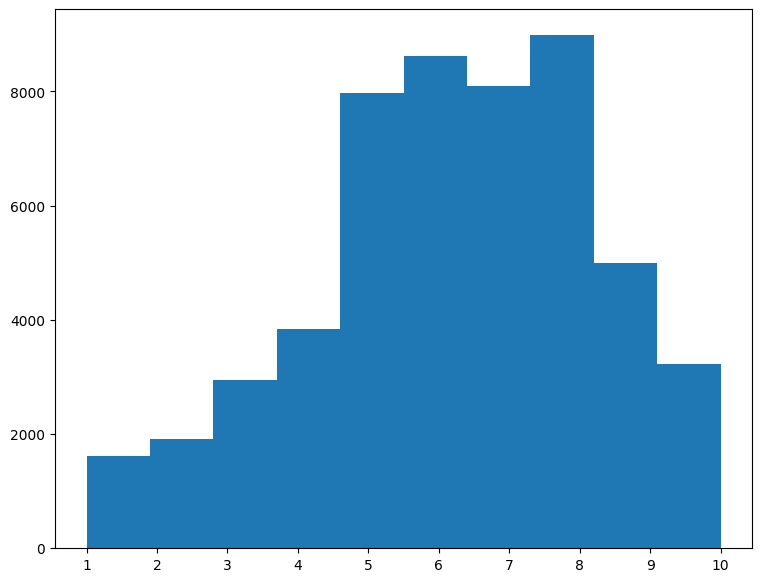

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 7))
plt.hist(y, bins=10)
plt.xticks(np.arange(1, 11, 1))
plt.show()

Распределение целевой переменной ожидаемое, больше смещено в сторону 5+

In [38]:
y.value_counts().sort_index()

target
1.0     1624
2.0     1916
3.0     2940
4.0     3832
5.0     7970
6.0     8616
7.0     8099
8.0     8989
9.0     4989
10.0    3225
Name: count, dtype: int64

In [39]:
X.head()

,count_passed,count_failed,last_it_grade,mean_ie_grade,grader_overall_mean,last_non_zero,variance_non_zero,min_non_zero,КР сумма_Рейтинг 22-23 года.csv,КР сумма норм_Рейтинг 22-23 года.csv,...,SVD_21,SVD_22,SVD_23,SVD_24,SVD_25,SVD_26,SVD_27,SVD_28,SVD_29,SVD_30
1,1,0,0.0,6.0,0.00,0.00,0.000000,0.0,0.0,0.00,...,-0.008073,0.407286,-0.207457,0.008115,0.725634,0.310384,-0.073257,-0.322501,2.468613,-0.607697
2,1,0,0.0,8.0,0.00,0.00,0.000000,0.0,0.0,0.00,...,-0.012636,-0.063638,0.165860,0.055099,-0.956601,-0.482328,-0.116165,0.475851,-2.517409,2.861124
3,0,1,0.0,2.0,6.83,6.83,1.118633,6.0,224.0,271.16,...,-0.118471,1.013388,1.220962,0.453876,-0.795201,-0.715727,0.436410,-0.890911,0.072477,-0.307614
4,0,1,0.0,3.0,6.83,6.83,1.118633,6.0,224.0,271.16,...,-0.118471,1.013388,1.220962,0.453876,-0.795201,-0.715727,0.436410,-0.890911,0.072477,-0.307614
5,1,0,0.0,7.0,6.83,6.83,1.118633,6.0,224.0,271.16,...,-0.118471,1.013388,1.220962,0.453876,-0.795201,-0.715727,0.436410,-0.890911,0.072477,-0.307614


In [40]:
print("failed exams", len(y[y < 4]) / len(y))
print("passed exams", len(y[y >= 4]) / len(y))


failed exams 0.12413793103448276
passed exams 0.8758620689655172


In [41]:
X_dead = X.drop(columns=['mean_ie_grade', 'last_it_grade', 'count_passed', 'count_failed'])

На данный момент получили обучающую выборку, теперь нужно разделить ее на тренировочную и тестовую в пропорции 70/30 и замерить качество на разных моделях.

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dead, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(36540, 72) (36540,)
(15660, 72) (15660,)


# Бейзлайн

Теперь займемся обучением моделей и замером качества, измерять качество будем по RMSE для регрессии и Precision / Recall, Roc-AUC для классификации (вероятностей).

Начнем с линейной регрессии, только не забудем нормализовать признаки.

Теперь обучим бейзлайн для получения вероястей, это будет Логистическая Регрессия

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the scaler
scaler = StandardScaler()

# Fit scaler on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_scaled = scaler.fit_transform(y_train_reshaped)
y_test_scaled = scaler.transform(y_test_reshaped)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

# Make predictions
y_pred_train_raw = model.predict(X_train_scaled)
y_pred_test_raw = model.predict(X_test_scaled)

y_pred_train = scaler.inverse_transform(y_pred_train_raw.reshape(-1, 1)).ravel()
y_pred_test = scaler.inverse_transform(y_pred_test_raw.reshape(-1, 1)).ravel()

# Calculate RMSE for both training and test sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Training RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')

print(f'Scaled Training RMSE: {np.sqrt(mean_squared_error(y_train_scaled, y_pred_train_raw)):.4f}')
print(f'Scaled Test RMSE: {np.sqrt(mean_squared_error(y_test_scaled, y_pred_test_raw)):.4f}')


# Optional: Print feature coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', key=lambda x: abs(x), ascending=False).head(10)
print('\nFeature Coefficients:')
print(feature_importance)

Training RMSE: 2.0025
Test RMSE: 2.0135
Scaled Training RMSE: 0.9008
Scaled Test RMSE: 0.9058

Feature Coefficients:
                                     Feature  Coefficient
13    Место в кампусе_Рейтинг 22-23 года.csv    -7.214959
10         Перцентиль_Рейтинг 22-23 года.csv     7.016222
32         Перцентиль_Рейтинг 23-24 года.csv     1.616820
28        Место на ОП_Рейтинг 23-24 года.csv    -1.104408
25    Место в кампусе_Рейтинг 21-22 года.csv    -1.006996
24        Место на ОП_Рейтинг 21-22 года.csv     0.761946
29    Место в кампусе_Рейтинг 23-24 года.csv    -0.649380
12        Место на ОП_Рейтинг 22-23 года.csv     0.630683
22         Перцентиль_Рейтинг 21-22 года.csv     0.620896
14  Место на Курсе-ОП_Рейтинг 22-23 года.csv    -0.572999


In [44]:
y_train_binary = (y_train >= 4).astype(int)
y_test_binary = (y_test >= 4).astype(int)

/Users/k.agliev/Documents/course-project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


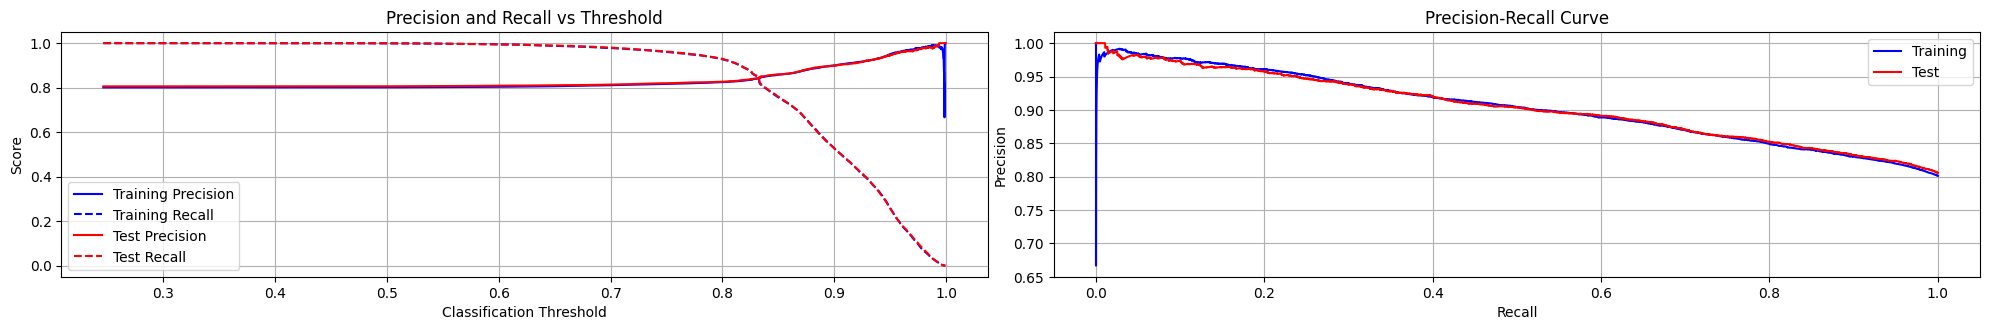


Metrics with optimal threshold:

Training metrics:
Precision: 0.8960
Recall: 0.5581
F1: 0.6878
AUC 0.7024065652566415

Test metrics:
Precision: 0.8954
Recall: 0.5556
F1: 0.6857
AUC 0.69678963002146


Text(0.5, 23.52222222222222, 'Predicted Label')

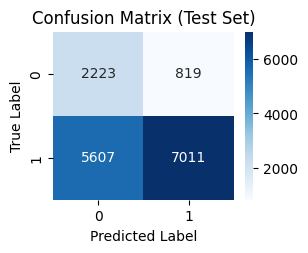

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,confusion_matrix, recall_score, roc_auc_score, roc_curve, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize model
log_reg = LogisticRegression(
    max_iter=1,
    class_weight={0: 1, 1: 2},
    penalty='elasticnet',
    solver='saga',
    C=0.1,
    l1_ratio=0.5
)

log_reg.fit(X_train_scaled, y_train_binary)

# Make predictions (probabilities)
y_pred_train_proba = log_reg.predict_proba(X_train_scaled)[:, 1]
y_pred_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Calculate precision-recall curves
train_precision, train_recall, train_thresholds = precision_recall_curve(y_train_binary, y_pred_train_proba)
test_precision, test_recall, test_thresholds = precision_recall_curve(y_test_binary, y_pred_test_proba)

# Create figure with multiple subplots
plt.figure(figsize=(20, 6))

# Plot 1: Precision-Recall vs Threshold
plt.subplot(2, 2, 1)
# Add small epsilon to avoid log(0)
epsilon = 1e-8
plt.plot(train_thresholds, train_precision[:-1], 'b-', label='Training Precision')
plt.plot(train_thresholds, train_recall[:-1], 'b--', label='Training Recall')
plt.plot(test_thresholds, test_precision[:-1], 'r-', label='Test Precision')
plt.plot(test_thresholds, test_recall[:-1], 'r--', label='Test Recall')
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)

# Plot 2: Precision vs Recall
plt.subplot(2, 2, 2)
plt.plot(train_recall, train_precision, 'b-', label='Training')
plt.plot(test_recall, test_precision, 'r-', label='Test')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

# Plot 3: F1 Score vs Threshold
# Calculate F1 scores for different thresholds

plt.tight_layout()
plt.show()


optimal_threshold = np.quantile(y_pred_test_proba, 0.5)

# Print metrics with optimal threshold
y_pred_train_binary = (y_pred_train_proba >= optimal_threshold).astype(int)
y_pred_test_binary = (y_pred_test_proba >= optimal_threshold).astype(int)

print("\nMetrics with optimal threshold:")
print("\nTraining metrics:")
print(f"Precision: {precision_score(y_train_binary, y_pred_train_binary):.4f}")
print(f"Recall: {recall_score(y_train_binary, y_pred_train_binary):.4f}")

train_pred = (y_pred_train_proba >= optimal_threshold).astype(int)
train_prec = precision_score(y_train_binary, train_pred)
train_rec = recall_score(y_train_binary, train_pred)
train_f1 = 2 * (train_prec * train_rec) / (train_prec + train_rec + epsilon)
    
print(f"F1: {2 * (train_prec * train_rec) / (train_prec + train_rec + epsilon):.4f}")
print("AUC",roc_auc_score(y_train_binary, y_pred_train_proba))

print("\nTest metrics:")
print(f"Precision: {precision_score(y_test_binary, y_pred_test_binary):.4f}")
print(f"Recall: {recall_score(y_test_binary, y_pred_test_binary):.4f}")

test_pred = (y_pred_test_proba >= optimal_threshold).astype(int)
test_prec = precision_score(y_test_binary, test_pred)
test_rec = recall_score(y_test_binary, test_pred)
test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec + epsilon)
print(f"F1: {2 * (test_prec * test_rec) / (test_prec + test_rec + epsilon):.4f}")
print("AUC", roc_auc_score(y_test_binary, y_pred_test_proba))

plt.subplot(2, 2, 4)
cm = confusion_matrix(y_test_binary, (y_pred_test_proba >= optimal_threshold).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


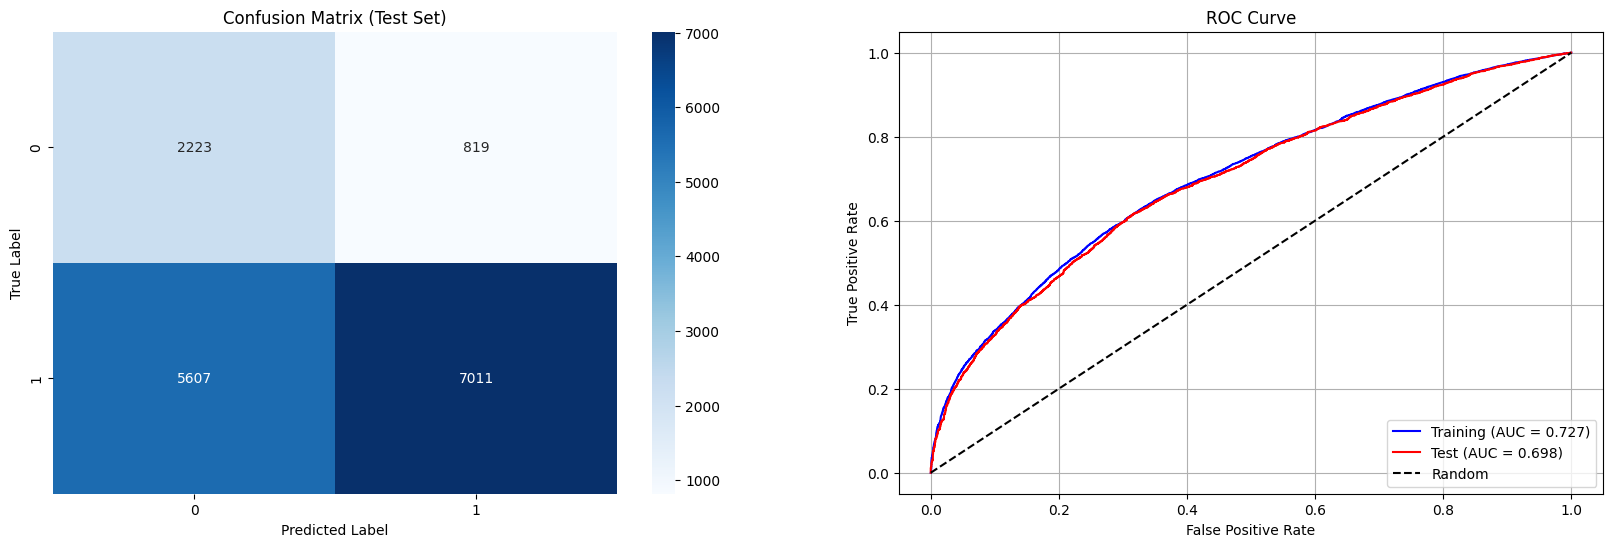

In [46]:
plt.figure(figsize=(20, 6))

# Plot 1: Precision-Recall vs Threshold
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_binary, (y_pred_test_proba >= optimal_threshold).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 2, 2)
fpr_train, tpr_train, _ = roc_curve(y_train_binary, y_pred_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_binary, y_pred_test_proba)

# Plot ROC curves
plt.plot(fpr_train, tpr_train, 'b-', 
         label=f'Training (AUC = 0.727)')
plt.plot(fpr_test, tpr_test, 'r-', 
         label=f'Test (AUC = 0.698)')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Улучшение результата

Теперь воспользуемся сложными моделями - градиентный бустинг, так же посмотрим на предсказание оценки и вероятности и посчитаем метрики, в конце сравним с бейзлайном


Regression Metrics:
Final Training RMSE: 1.8601
Final Test RMSE: 1.9338
Binary Classification Metrics (threshold = 4):

Training metrics:
Precision: 0.7620
Recall: 0.8104
AUC: 0.7699

Test metrics:
Precision: 0.7465
Recall: 0.8033
AUC: 0.7374


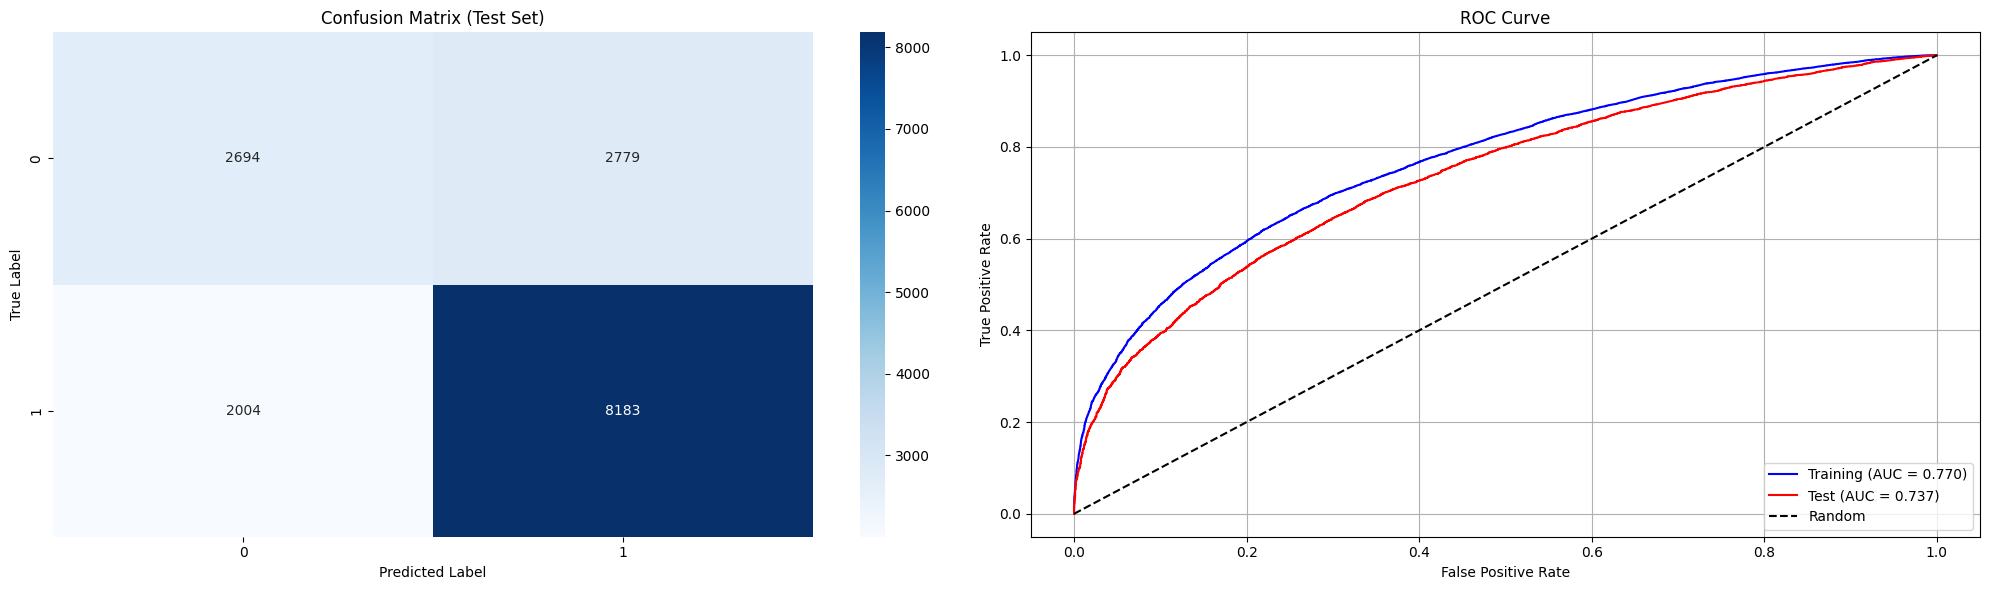


Feature Importances:
                                    Feature  Importance
3                              min_non_zero    0.120512
40                      Балл_ЕГЭ_математика    0.103611
11  Минимальный балл_Рейтинг 22-23 года.csv    0.097053
66                                   SVD_25    0.060002
50                                    SVD_9    0.038827
58                                   SVD_17    0.034762
52                                   SVD_11    0.034667
60                                   SVD_19    0.032790
23  Минимальный балл_Рейтинг 21-22 года.csv    0.027769
4           КР сумма_Рейтинг 22-23 года.csv    0.024814


In [47]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize model
gb_model = GradientBoostingRegressor(
    n_estimators=300,        # number of trees
    learning_rate=0.02,      # shrinkage rate
    max_depth=5,            # depth of each tree
    subsample=0.8,          # fraction of samples for each tree
    random_state=42
)

# Train model and store losses
gb_model.fit(X_train_scaled, y_train)

# Get staged predictions and calculate RMSE for each stage
train_losses = []
test_losses = []

for y_train_pred in gb_model.staged_predict(X_train_scaled):
    train_losses.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    
for y_test_pred in gb_model.staged_predict(X_test_scaled):
    test_losses.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# Make final predictions
y_pred_train = gb_model.predict(X_train_scaled)
y_pred_test = gb_model.predict(X_test_scaled)

# Convert to binary predictions using threshold of 4
threshold = np.quantile(y_pred_test, 0.3)
y_pred_train_binary = (y_pred_train >= threshold).astype(int)
y_pred_test_binary = (y_pred_test >= threshold).astype(int)
y_train_binary = (y_train >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)


# Print regression metrics
print(f"\nRegression Metrics:")
print(f"Final Training RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")

# Calculate binary classification metrics
print("Binary Classification Metrics (threshold = 4):")
print("\nTraining metrics:")
print(f"Precision: {precision_score(y_train_binary, y_pred_train_binary):.4f}")
print(f"Recall: {recall_score(y_train_binary, y_pred_train_binary):.4f}")
print(f"AUC: {roc_auc_score(y_train_binary, y_pred_train):.4f}")

print("\nTest metrics:")
print(f"Precision: {precision_score(y_test_binary, y_pred_test_binary):.4f}")
print(f"Recall: {recall_score(y_test_binary, y_pred_test_binary):.4f}")
print(f"AUC: {roc_auc_score(y_test_binary, y_pred_test):.4f}")

# Create figure with multiple subplots
plt.figure(figsize=(20, 6))

# # Plot 1: Learning curves
# plt.subplot(1, 3, 1)
# plt.plot(train_losses, label='Training RMSE', color='blue')
# plt.plot(test_losses, label='Test RMSE', color='red')
# plt.xlabel('Number of Trees')
# plt.ylabel('RMSE')
# plt.title('Gradient Boosting Learning Curve')
# plt.legend()
# plt.grid(True)

# Plot 2: Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_binary, y_pred_test_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 3: ROC curve
plt.subplot(1, 2, 2)
# Calculate ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train_binary, y_pred_train)
fpr_test, tpr_test, _ = roc_curve(y_test_binary, y_pred_test)

# Plot ROC curves
plt.plot(fpr_train, tpr_train, 'b-', 
         label=f'Training (AUC = {roc_auc_score(y_train_binary, y_pred_train):.3f})')
plt.plot(fpr_test, tpr_test, 'r-', 
         label=f'Test (AUC = {roc_auc_score(y_test_binary, y_pred_test):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

print("\nFeature Importances:")
print(feature_importance)

Очень неплохой результат для регрессии, это значит, что мы почти всегда уверены что студент сдаст либо на x либо на x +- 1

Еще один подход, который можно использовать, это использовать классификацию, то есть предсказывать не оценку, а факт сдачи экзамена. Для этого нужно будет перевести целевую переменную в бинарную, сделаем для этого `binary_target = (target < 4)`, то есть не сдавшие экзамен будут считаться положительными примерами, а не сдавшие - отрицательными.

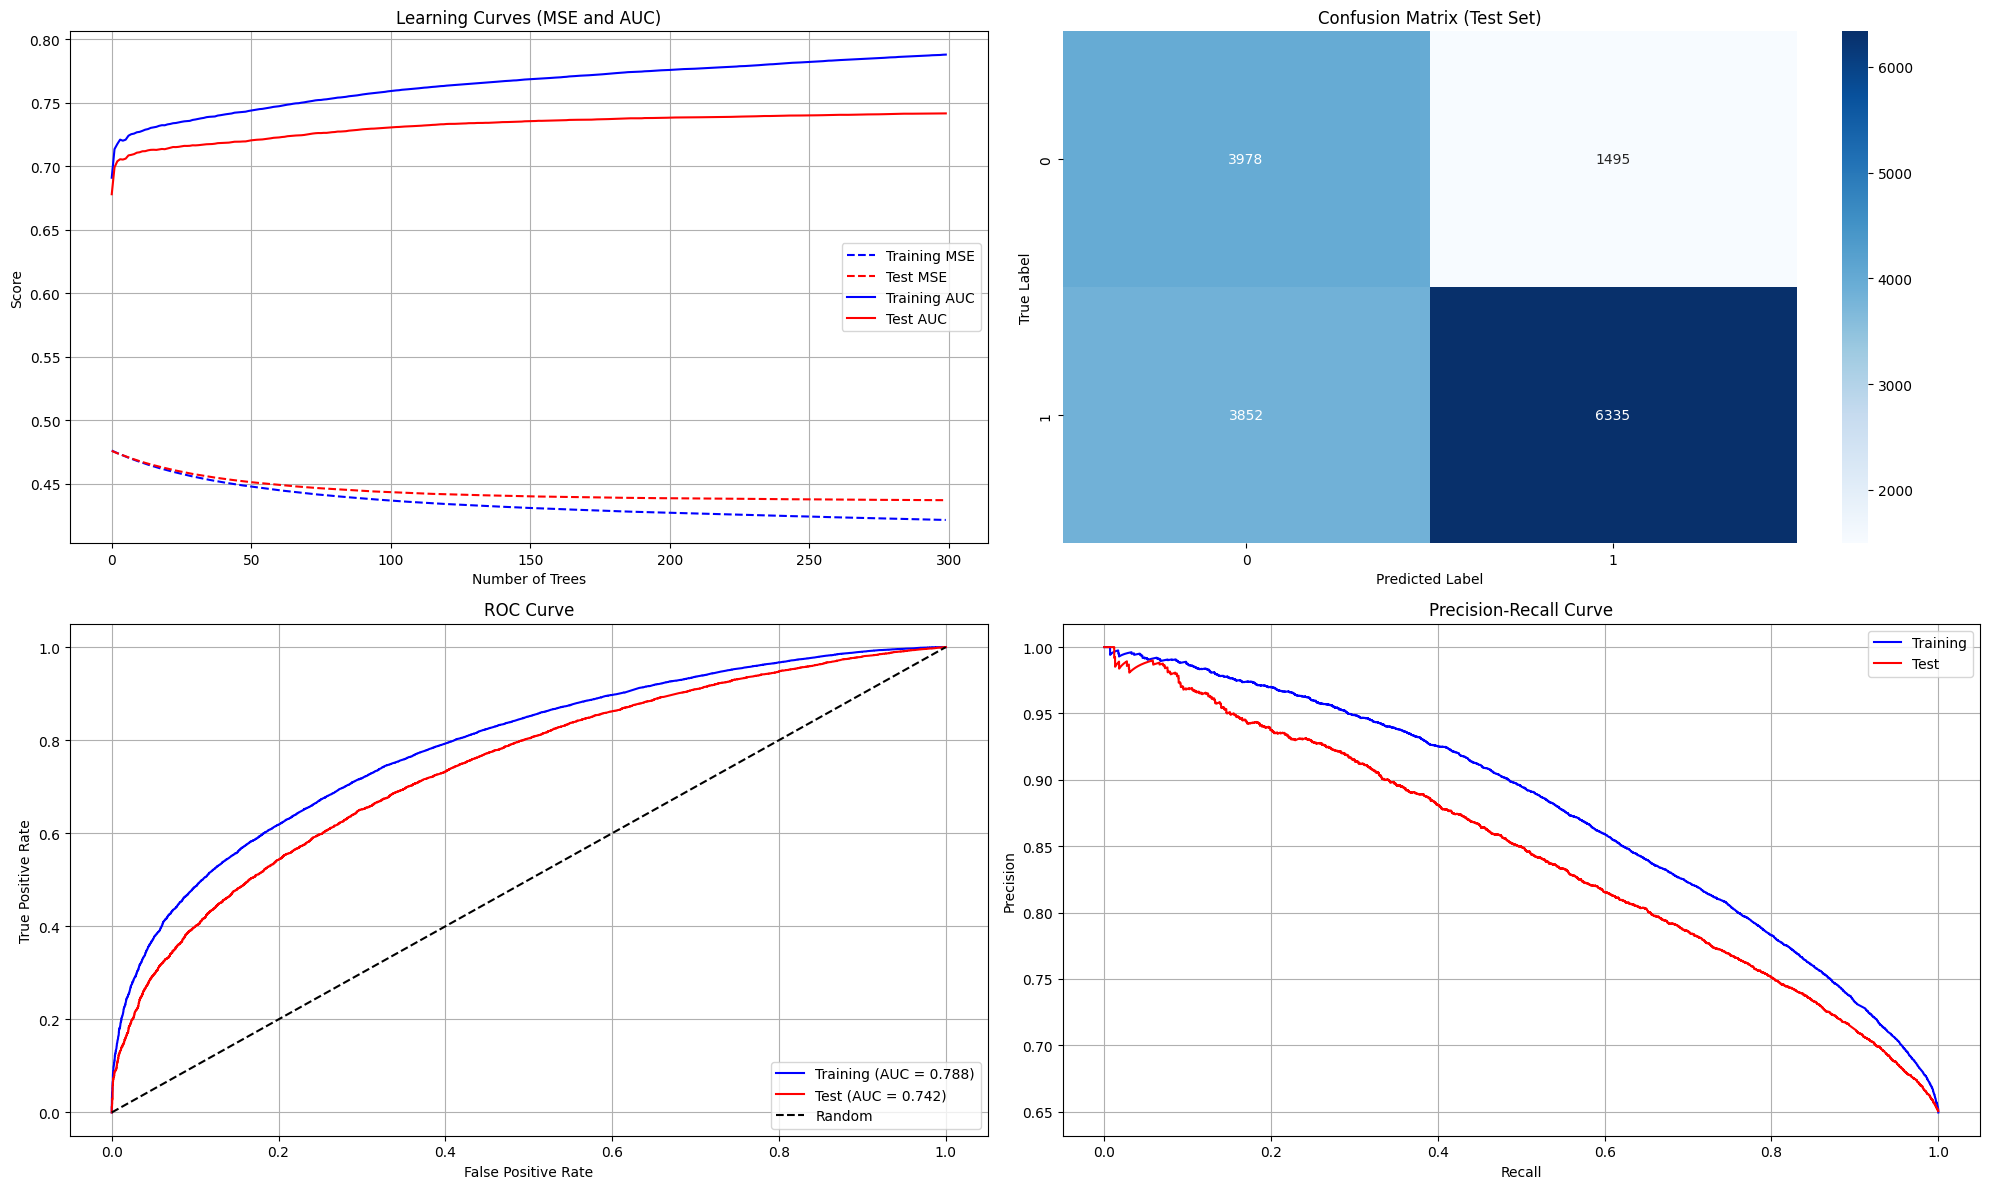


Optimal threshold (based on Test F1 score): 0.6527

Training metrics:
Precision: 0.8429
Recall: 0.6412
AUC: 0.7879

Test metrics:
Precision: 0.8091
Recall: 0.6219
AUC: 0.7416

Regression Metrics:
Final Training RMSE: 5.8851
Final Test RMSE: 5.9060

Top 10 Most Important Features:
                                    Feature  Importance
40                      Балл_ЕГЭ_математика    0.117726
3                              min_non_zero    0.075382
11  Минимальный балл_Рейтинг 22-23 года.csv    0.053962
66                                   SVD_25    0.052945
42                                    SVD_1    0.044110
50                                    SVD_9    0.041832
23  Минимальный балл_Рейтинг 21-22 года.csv    0.036241
52                                   SVD_11    0.033062
58                                   SVD_17    0.030161
44                                    SVD_3    0.023411


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize model
gb_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.02,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

# Train model
gb_clf.fit(X_train_scaled, y_train_binary)

# Get staged predictions and calculate metrics for each stage
train_losses = []
test_losses = []
train_aucs = []
test_aucs = []

for y_train_pred in gb_clf.staged_predict_proba(X_train_scaled):
    train_losses.append(mean_squared_error(y_train_binary, y_train_pred[:, 1]))
    train_aucs.append(roc_auc_score(y_train_binary, y_train_pred[:, 1]))
    
for y_test_pred in gb_clf.staged_predict_proba(X_test_scaled):
    test_losses.append(mean_squared_error(y_test_binary, y_test_pred[:, 1]))
    test_aucs.append(roc_auc_score(y_test_binary, y_test_pred[:, 1]))

# Make final predictions (probabilities)
y_pred_train_proba = gb_clf.predict_proba(X_train_scaled)[:, 1]
y_pred_test_proba = gb_clf.predict_proba(X_test_scaled)[:, 1]

optimal_threshold = np.quantile(y_pred_test_proba, 0.107)
# 0.107 = proportion of negative examples in set

# raw values
y_pred_train = gb_clf.predict(X_train_scaled)
y_pred_test = gb_clf.predict(X_test_scaled)

# Calculate precision-recall curves
train_precision, train_recall, train_thresholds = precision_recall_curve(y_train_binary, y_pred_train_proba)
test_precision, test_recall, test_thresholds = precision_recall_curve(y_test_binary, y_pred_test_proba)

# Create figure with multiple subplots
plt.figure(figsize=(20, 12))

# Plot 1: Learning curves (MSE and AUC)
plt.subplot(2, 2, 1)
plt.plot(np.sqrt(train_losses), label='Training MSE', color='blue', linestyle='--')
plt.plot(np.sqrt(test_losses), label='Test MSE', color='red', linestyle='--')
plt.plot(train_aucs, label='Training AUC', color='blue')
plt.plot(test_aucs, label='Test AUC', color='red')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Learning Curves (MSE and AUC)')
plt.legend()
plt.grid(True)

# Plot 2: Confusion Matrix
plt.subplot(2, 2, 2)
y_pred_test_binary = (y_pred_test_proba >= optimal_threshold).astype(int)  # using 0.5 as default threshold
cm = confusion_matrix(y_test_binary, y_pred_test_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 3: ROC curve
plt.subplot(2, 2, 3)
# Calculate ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train_binary, y_pred_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_binary, y_pred_test_proba)

plt.plot(fpr_train, tpr_train, 'b-', 
         label=f'Training (AUC = {roc_auc_score(y_train_binary, y_pred_train_proba):.3f})')
plt.plot(fpr_test, tpr_test, 'r-', 
         label=f'Test (AUC = {roc_auc_score(y_test_binary, y_pred_test_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Plot 4: Precision-Recall curve
plt.subplot(2, 2, 4)
plt.plot(train_recall, train_precision, 'b-', label='Training')
plt.plot(test_recall, test_precision, 'r-', label='Test')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate metrics with optimal threshold
y_pred_train_binary = (y_pred_train_proba >= optimal_threshold).astype(int)
y_pred_test_binary = (y_pred_test_proba >= optimal_threshold).astype(int)

print(f"\nOptimal threshold (based on Test F1 score): {optimal_threshold:.4f}")

print("\nTraining metrics:")
print(f"Precision: {precision_score(y_train_binary, y_pred_train_binary):.4f}")
print(f"Recall: {recall_score(y_train_binary, y_pred_train_binary):.4f}")
print(f"AUC: {roc_auc_score(y_train_binary, y_pred_train_proba):.4f}")

print("\nTest metrics:")
print(f"Precision: {precision_score(y_test_binary, y_pred_test_binary):.4f}")
print(f"Recall: {recall_score(y_test_binary, y_pred_test_binary):.4f}")
print(f"AUC: {roc_auc_score(y_test_binary, y_pred_test_proba):.4f}")

# Print regression metrics
print(f"\nRegression Metrics:")
print(f"Final Training RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")

# Print feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_clf.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

print("\nTop 10 Most Important Features:")
print(feature_importance)


Training metrics:
Precision: 0.6998
Recall: 0.9563
AUC: 0.7879
F1: 0.8082

Test metrics:
Precision: 0.6887
Recall: 0.9454
AUC: 0.7416
F1: 0.7969


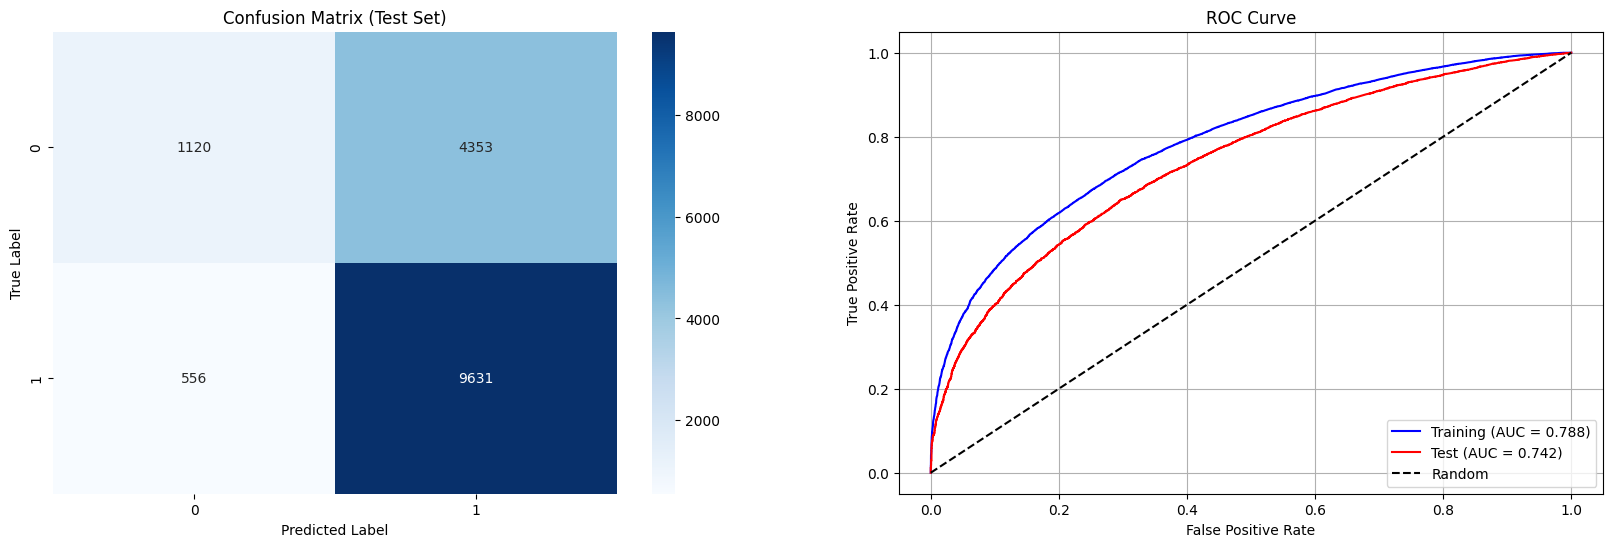

In [ ]:
from sklearn.metrics import f1_score


y_pred_train_proba = gb_clf.predict_proba(X_train_scaled)[:, 1]
y_pred_test_proba = gb_clf.predict_proba(X_test_scaled)[:, 1]

optimal_threshold = np.quantile(y_pred_test_proba, 0.107)

y_pred_train_binary = (y_pred_train_proba >= optimal_threshold).astype(int)
y_pred_test_binary = (y_pred_test_proba >= optimal_threshold).astype(int)

print("\nTraining metrics:")
print(f"Precision: {precision_score(y_train_binary, y_pred_train_binary):.4f}")
print(f"Recall: {recall_score(y_train_binary, y_pred_train_binary):.4f}")
print(f"AUC: {roc_auc_score(y_train_binary, y_pred_train_proba):.4f}")
print(f"F1: {f1_score(y_train_binary, y_pred_train_binary):.4f}")

print("\nTest metrics:")
print(f"Precision: {precision_score(y_test_binary, y_pred_test_binary):.4f}")
print(f"Recall: {recall_score(y_test_binary, y_pred_test_binary):.4f}")
print(f"AUC: {roc_auc_score(y_test_binary, y_pred_test_proba):.4f}")
print(f"F1: {f1_score(y_test_binary, y_pred_test_binary):.4f}")

plt.figure(figsize=(20, 6))

# Plot 2: Confusion Matrix
plt.subplot(1, 2, 1)
y_pred_test_binary = (y_pred_test_proba >= optimal_threshold).astype(int)  # using 0.5 as default threshold
cm = confusion_matrix(y_test_binary, y_pred_test_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 3: ROC curve
plt.subplot(1, 2, 2)
# Calculate ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train_binary, y_pred_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_binary, y_pred_test_proba)

plt.plot(fpr_train, tpr_train, 'b-', 
         label=f'Training (AUC = {roc_auc_score(y_train_binary, y_pred_train_proba):.3f})')
plt.plot(fpr_test, tpr_test, 'r-', 
         label=f'Test (AUC = {roc_auc_score(y_test_binary, y_pred_test_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

Поиграть с порогом бин классификации

In [50]:
%load_ext autoreload
%autoreload 2